# Introduction

Below is an analysis of the [MNIST dataset](https://www.kaggle.com/datasets/puneet6060/intel-image-classification) located at Kaggle. The code below uses two algorithms for classification:

- Sci-Learn to create a Multi-Layered Perceptron (MLP)
- PyTorch to create a CNN for classification. 



The model training code was run on an AWS EC2 p3.2xlarge with 8 CPUs with 61 gigs of memory and 1 GPU with 16 gigs of memory.

# Load The Data

The training and test images are loaded.

In [1]:
%%time
import cv2
import os
import numpy as np
IMGSIZE = (128, 128)
CNAMES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
X_tr, y_tr, X_ts, y_ts = [], [], [], []
for label in CNAMES:
    path = './seg_train/seg_train/' + label
    for f in sorted([_ for _ in os.listdir(path) if _.lower().endswith('.jpg')]):
        X_tr += [cv2.resize(cv2.imread(os.path.join(path,f)), IMGSIZE)]
        y_tr += [CNAMES.index(label)]
    path = './seg_test/seg_test/' + label
    for f in sorted([_ for _ in os.listdir(path) if _.lower().endswith('.jpg')]):
        X_ts += [cv2.resize(cv2.imread(os.path.join(path,f)), IMGSIZE)]
        y_ts += [CNAMES.index(label)]

CPU times: user 6.21 s, sys: 1.61 s, total: 7.82 s
Wall time: 6.17 s


Below, a few of the training and test images are displayed. 

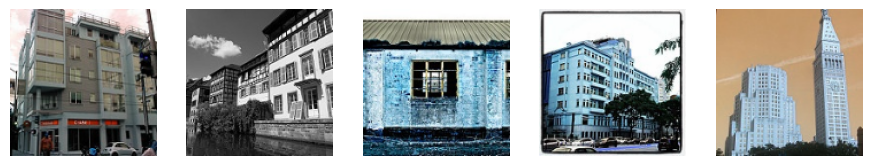

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 11 ,8
ifig, ax = plt.subplots(1,5)
ax[0].imshow( Image.fromarray(X_tr[50], 'RGB') );ax[0].axis('off')
ax[1].imshow( Image.fromarray(X_tr[150], 'RGB') );ax[1].axis('off')
ax[2].imshow( Image.fromarray(X_tr[250], 'RGB') );ax[2].axis('off')
ax[3].imshow( Image.fromarray(X_ts[50], 'RGB') );ax[3].axis('off')
ax[4].imshow( Image.fromarray(X_ts[150], 'RGB') );rtrn = ax[4].axis('off')

The images have 3 channels of RGB. The distribution of the target variable is calculated below.

In [3]:
import pandas as pd
y_tr_df = pd.DataFrame(data={'Class':y_tr}) 
pd.DataFrame({'Frequency':y_tr_df['Class'].value_counts().sort_index().sort_index(),
                            'Distribution':y_tr_df['Class'].value_counts(normalize=True).sort_index()})

,Frequency,Distribution
Class,,
0,2191,0.156121
1,2271,0.161821
2,2404,0.171298
3,2512,0.178994
4,2274,0.162035
5,2382,0.169731


It appears the categories are (approximately) equally balanced. The accuracy metric will be used for performance evaluations.


# Pre-process the data 

Below the training and test datasets are converted to Numpy arrays.

In [4]:
import numpy as np
X_tr = np.array(X_tr)
y_tr = np.array(y_tr)
print(f'Training shape: {X_tr.shape}')
print(f'Labelshape: {y_tr.shape}')
X_ts = np.array(X_ts)
y_ts = np.array(y_ts)
print(f'Training shape: {X_ts.shape}')
print(f'Labelshape: {y_ts.shape}')

Training shape: (14034, 128, 128, 3)
Labelshape: (14034,)
Training shape: (3000, 128, 128, 3)
Labelshape: (3000,)


To prepare the data for input into a regular fully connected NN, the 4D data is flattened into a 2D matrix.

In [5]:
X_tr_2d = X_tr.reshape((X_tr.shape[0],X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
X_ts_2d = X_ts.reshape((X_ts.shape[0],X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))
print(f'Training shape: {X_tr_2d.shape}')
print(f'Test shape: {X_tr_2d.shape}')

Training shape: (14034, 49152)
Test shape: (14034, 49152)


Thats a lot of variables! Feature selection is needed. PCA will be used. The data is first scaled between 0 and 1.

In [6]:
%%time
from sklearn.preprocessing import MinMaxScaler
mmc = MinMaxScaler(feature_range=(0, 1))
X_tr_sc = mmc.fit_transform(X_tr_2d)
X_ts_sc = mmc.transform(X_ts_2d)

CPU times: user 2.16 s, sys: 915 ms, total: 3.07 s
Wall time: 3.09 s


Below are summary stats for the scaled data.

In [7]:
print(f'Training Min, Max: {X_tr_sc.min()}, {X_tr_sc.max()}  ' )
print(f'Sample values: {X_tr_sc[0][0:5]}')
print(f'Test Min, Max: {X_ts_sc.min()}, {X_ts_sc.max()}  ' )
print(f'Sample values: {X_ts_sc[0][0:5]}')

Training Min, Max: 0.0, 1.0  
Sample values: [0.96078431 0.96862745 0.96862745 0.96078431 0.96862745]
Test Min, Max: -0.003937007874015748, 1.007905138339921  
Sample values: [0.68235294 0.47058824 0.36862745 0.72941176 0.54509804]


This looks correct. Now lets chart the PCA variance explained for `n` components between 1 and 30. 

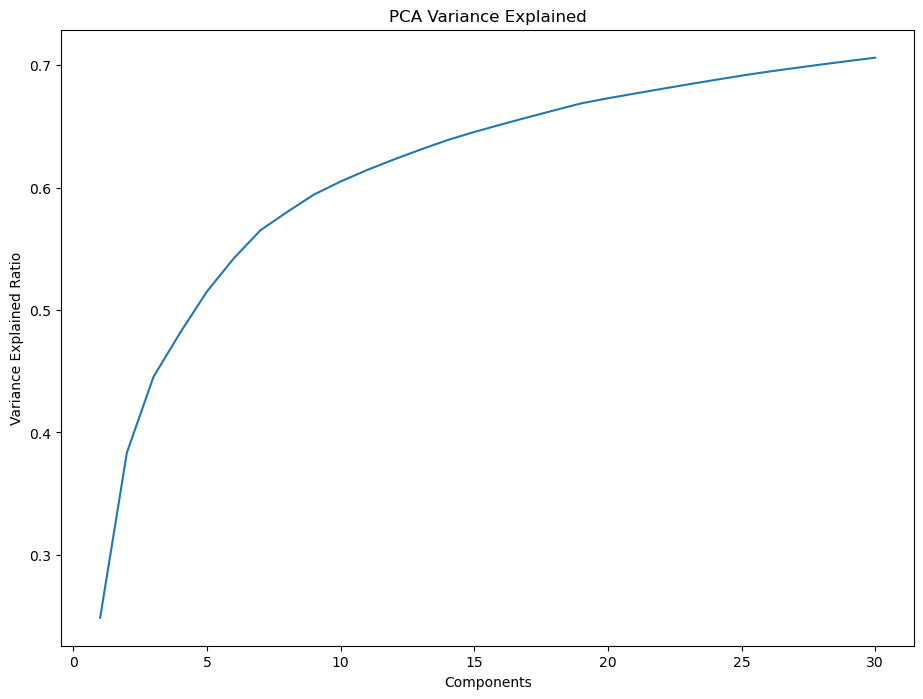

CPU times: user 2h 15min 4s, sys: 23min 19s, total: 2h 38min 23s
Wall time: 5min 49s


In [8]:
%%time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

var_expl = []
for n in list(range(1,31)):
    print(f'Iteration {n} ...',end='\r')
    pca = PCA(n_components=n)
    pca.fit(X_tr_sc)
    var_expl.append(sum(pca.explained_variance_ratio_))

plt.plot(list(range(1,31)), var_expl)
plt.xlabel("Components") 
plt.ylabel("Variance Explained Ratio") 
plt.title("PCA Variance Explained")  
plt.show()

# Classification: MLP 

It appears the variance explained stabilizes around 30 components. Therefore, the first 30 PCA components will be used as features in the regular NN. A `Scikit-learn's` `MLPClassifier` will be used to model the data. Spot testing different network architectures revealed networks larger than 3 or 4 layers were able to increase the reclassification accuracy but perform poorly on the test data accuracy, indicating overfitting. The loss function for all network architectures tested seemed to stabilize around 2,500 epocs. Finally, Kernel PCA using RBF was tried but produced approximately the same results as PCA but took much longer to fit. 

Below a two layer MLP classifer is fitted and its reclassification and test accuracy is calculated.

In [9]:
%%time
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

mlp = MLPClassifier(hidden_layer_sizes=(30, 20), max_iter=3000, 
                    learning_rate_init=0.001, batch_size=5000, 
                    alpha=0.0001, tol=0.0001, random_state=0, verbose=False)

import time
t0 = time.time()
pca = PCA(n_components=30)
X_tr_pca = pca.fit_transform(X_tr_sc)
print(f'PCA fit and transformation duration: {time.time() - t0:0.6f}')

pl = Pipeline(steps=[
    ('model',  mlp) 
    ])

rtrn = pl.fit(X_tr_pca, y_tr)
print(f'Fit done...')
from sklearn.metrics import accuracy_score
y_pred = pl.predict(X_tr_pca)
print(f'Reclassification accuracy: {accuracy_score(y_tr, y_pred):.6f}')
X_ts_pca = pca.transform(X_ts_sc)
y_pred = pl.predict(X_ts_pca)
accuracy_score(y_ts, y_pred)
print(f'Test accuracy: {accuracy_score(y_ts, y_pred):.6f}')

PCA fit and transformation duration: 13.225288
Fit done...
Reclassification accuracy: 0.697235
Testa accuracy: 0.613667
CPU times: user 10min 58s, sys: 9min 47s, total: 20min 45s
Wall time: 40.8 s


## Performance Summary

The model has a single-run reclassification accuracy of $\approx$ 70% and test data accuracy of 61%.

Below 10-fold CV is calculated for the model.

In [10]:
%%time
from sklearn.model_selection import StratifiedKFold, cross_val_score
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pl, X_tr_pca, y_tr, cv=kfold, scoring='accuracy', n_jobs=35)
print(f'10-fold CV mean accuracy: {results.mean():.6f} {chr(177)} {results.std():.6f}')

10-fold CV mean accuracy: 0.618141 ± 0.015029
CPU times: user 77.5 ms, sys: 505 ms, total: 582 ms
Wall time: 20.8 s


The average 10-fold 62% accuracy is consistent with the single run above.

# Classifier: Convolutional neural network (CNN)

Below a CNN similar to the code provided in the Module 12 notebook is used to model the image data. I made a few changes:

1. The class used to implement the model subclasses `torch.nn.Sequential` instead of having it as an attribute. 
1. The PyTorch `ImageFolder` loader class is used to load the training and test datasets.
1. The CNN hidden layers output sizes are 64 and 128. As these 150x150 images are bigger than the digits 28x28 images, this seemed like a good idea.  
1. A `ReLu` layer was added between the two linear layers than are feed by the CNN layers.

First, the availability of the GPU is confirmed.

In [1]:
%%time
import numpy as np
import torch
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder

print(f'PyTorch version= {torch.__version__}')
print(f'CUDA available= {torch.cuda.is_available()}')  # CUDA optional - True when GPU present, CUDA installed
print(f'Number of GPUs: {torch.cuda.device_count()}')

PyTorch version= 2.0.1
CUDA available= True
Number of GPUs: 1
CPU times: user 2.05 s, sys: 678 ms, total: 2.72 s
Wall time: 1.98 s


Next the datasets are loaded. The image is first resized from 150x150 to 128x128. The call to `torchvision.transforms.ToTensor` scales the input data between [0, 1]. The call to `torchvision.transforms.Normalize` will further scale the data by a mean and standard deviation. I followed the Module 12 digits example for the mean and standard deviation to use.    

In [2]:
IMG_SIZE = 128
transform = tt.Compose([
        tt.Resize((IMG_SIZE,IMG_SIZE)),
        tt.ToTensor(),
        tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
train_ds = ImageFolder('./seg_train/seg_train/', transform)
test_ds = ImageFolder('./seg_test/seg_test/', transform)

A data loader for the training data is created. 

In [3]:
from torch.utils.data import  DataLoader
X_train_dl = DataLoader(train_ds, 500, shuffle=True, num_workers=3, pin_memory=True)

The input size for the first layer of the regular NN is calculated below.

In [4]:
IMG_CHANNEL=  3  # color channel
KERNEL_SIZE = 5 
MLP_HIDDEN= 64 # Hidden layer size
LAST_LINEAR_SIZE = 1024  # 1024 is arbitrary
N_CLASSES = 6  # output layer size

# Compute H, W for image size IMG_SIZE 
def findConv2dOutShape(_H, _W, _conv, _pool=2):
    kernel_size, stride, padding, dilation = _conv.kernel_size, _conv.stride, _conv.padding, _conv.dilation
    H = np.floor((_H+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    W = np.floor((_W+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)
    if _pool:
        H, W = H/_pool, W/_pool
    return int(H), int(W)
CH1 = findConv2dOutShape(IMG_SIZE, 
                         IMG_SIZE, torch.nn.Conv2d(3, MLP_HIDDEN, KERNEL_SIZE))
print(CH1)
CH2 = findConv2dOutShape(CH1[0], CH1[1], 
                         torch.nn.Conv2d(MLP_HIDDEN, MLP_HIDDEN * 2, KERNEL_SIZE))
print(CH2)

(62, 62)
(29, 29)


Below is the definition of the CNN model.

In [ ]:
import os
from torch.distributed import init_process_group, destroy_process_group
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP

In [ ]:
#self.gpu_id = int(os.environ["LOCAL_RANK"])
#device_type = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def ddp_setup():
    init_process_group(backend="nccl")
    torch.cuda.set_device(int(os.environ["LOCAL_RANK"]))
    
if torch.cuda.is_available():
    ddp_setup()
    device_type = torch.device(int(os.environ["LOCAL_RANK"]))
else: device_type = torch.device('cpu')

In [5]:
import torch.nn as nn
class RGBConv_v1(torch.nn.Sequential):  
    def __init__(self, epochs=100, eta=0.001, seed=0):
        super(RGBConv_v1, self).__init__()

        self.random = np.random.RandomState(seed)  # shuffle mini batches
        self.epochs = epochs
        self.eta = eta 
        self.optimizer = None
        this.save_every = 100
        this.snapshot_path = './snap.file'
        if os.path.exists(snapshot_path):
            print("Loading snapshot")
            self._load_snapshot(snapshot_path)        
        
        self.init_layers()
        
    def _load_snapshot(self, snapshot_path):
        loc = f"cuda:{device_type}"
        snapshot = torch.load(snapshot_path, map_location=loc)
        self.model.load_state_dict(snapshot["MODEL_STATE"])
        self.epochs_run = snapshot["EPOCHS_RUN"]
        print(f"Resuming training from snapshot at Epoch {self.epochs}")
    
    def _save_snapshot(self, epoch):
        snapshot = {
            "MODEL_STATE": self.module.state_dict(),
            "EPOCHS_RUN": epoch,
        }
        torch.save(snapshot, self.snapshot_path)
        print(f"Epoch {epoch} | Training snapshot saved at {self.snapshot_path}")
        
    def init_layers(self):
        
        print('Using RGBConv_v1 init_layers... ')
        
        self.append(nn.Conv2d(IMG_CHANNEL, MLP_HIDDEN, KERNEL_SIZE).to(device_type))
        self.append(nn.ReLU().to(device_type))
        self.append(nn.MaxPool2d(2).to(device_type))
        self.append(nn.BatchNorm2d(MLP_HIDDEN).to(device_type))

        self.append(nn.Conv2d(MLP_HIDDEN, MLP_HIDDEN * 2, KERNEL_SIZE).to(device_type))
        self.append(nn.ReLU().to(device_type))
        self.append(nn.MaxPool2d(2).to(device_type))

        self.append(nn.Flatten(start_dim=1).to(device_type))
        
        # CH2[0]*CH2[1] is computed in the above cell - findConv2dOutShape
        self.append(nn.Linear(MLP_HIDDEN*2 * CH2[0]*CH2[1], LAST_LINEAR_SIZE).to(device_type))
        self.append(nn.ReLU().to(device_type))  # NEW 
        self.append(nn.BatchNorm1d(LAST_LINEAR_SIZE).to(device_type))
        self.append(nn.Linear(LAST_LINEAR_SIZE, N_CLASSES).to(device_type))        
            

    def predict(self, _X):
        _X = _X.to(device_type, non_blocking=True)
        self.eval()
        with torch.no_grad():
            y_pred = np.argmax(self(_X).cpu(), axis=1)
        self.train()
        return y_pred.numpy()

    def fit(self, _X_train_dl, info=False):
        import sys
                
        self.optimizer = torch.optim.Rprop(self.parameters(), lr=self.eta)  # connect model to optimizer
        loss_func = torch.nn.CrossEntropyLoss()

        for i in range(self.epochs):
            if info:
                print(f'Epoc {i+1}...',end='\n')

            for _X, _y in _X_train_dl:
                _X = _X.to(device_type, non_blocking=True)
                _y = _y.to(device_type, non_blocking=True)
                self.optimizer.zero_grad()
                net_out = self(_X)
                loss = loss_func(net_out, _y)
                loss.backward()
                self.optimizer.step()
                if info:
                    sys.stderr.write(f"\r{i+1:03d} Loss: {loss.item():6.5f}")
                    sys.stderr.flush()
                        if self.gpu_id == 0 and epoch % self.save_every == 0:
            if device_type == 0 and i % self.save_every == 0:
                self._save_snapshot(i)
        return self

Lets do a single fitting and calculate the reclassification and test accuracies.

First, the model is fitted using 10 epocs. The debug below shows the loss on the last batch iteration for each epoc. The 16 gigs of memory available to the GPU limited the batch sized using for the fitting. It seemed batch sizes larger than 500 would cause PyTorch to report `CUDA out of memory` errors. 

In [6]:
%%time
 self.model = DDP(self.model, device_ids=[self.gpu_id])
mlp1 = RGBConv_v1(epochs=10, eta=0.0001)
mlp1 = mlp1.to(device_type)
mlp1 = mlp1.fit(X_train_dl, info=True)

Using RGBConv_v1 init_layers... 
Epoc 1...


001 Loss: 0.59795

Epoc 2...


002 Loss: 0.39794

Epoc 3...


003 Loss: 0.56417

Epoc 4...


004 Loss: 0.29427

Epoc 5...


005 Loss: 0.44676

Epoc 6...


006 Loss: 0.35608

Epoc 7...


007 Loss: 0.19296

Epoc 8...


008 Loss: 0.35192

Epoc 9...


009 Loss: 0.24435

Epoc 10...


010 Loss: 0.27083

CPU times: user 51.9 s, sys: 24.7 s, total: 1min 16s
Wall time: 2min 53s


## Performance Summary


Reclassification accuracy is calculated. 

In [7]:
%%time
from sklearn.metrics import accuracy_score
y_preds = []
for _X, _y in X_train_dl:
    y_pred = mlp1.predict(_X)
    y_preds.append( accuracy_score(_y, y_pred) )
print(f'Reclassification accuracy: {np.mean(y_preds):.6f}')

Reclassification accuracy: 0.932357
CPU times: user 2.45 s, sys: 1.27 s, total: 3.72 s
Wall time: 17.5 s


Now the test accuracy is calculated. 

In [8]:
%%time
from sklearn.metrics import accuracy_score
X_test_dl = DataLoader(test_ds, 1000, num_workers=3, pin_memory=True)
y_preds = []
for _X, _y in X_test_dl:
    y_pred = mlp1.predict(_X)
    y_preds.append( accuracy_score(_y, y_pred) )
print(f'Test accuracy: {np.mean(y_preds):.6f}')

Test accuracy: 0.812000
CPU times: user 420 ms, sys: 846 ms, total: 1.27 s
Wall time: 5.26 s


The PyTorch CNN model's reclassification accuracy of 93% and test accuracy of 81% beats the `scikit-learn MLPClassifier's` 70% and 61% accuracies. The PyTorch model's accuracy could be improved with larger batch sizes and number of training epocs, but a more capable training environment would be needed to make the training times reasonable and handle the extra GPU memory needed.

A 5-fold CV will now be done on the PyTorch CNN model. I limited this experiment to 5-folds as the process would take too long otherwise, costing a bit more than I was willing to spend on Amazon's AWS. Below the CV method is defined. I used the following __[source](https://saturncloud.io/blog/how-to-use-kfold-cross-validation-with-dataloaders-in-pytorch/)__ as a guide for the implementation. 

In [6]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

epocs = 10
device = device_type

def run_k_fold(get_model):

    k_folds = 5
    batch_size = 500

    # Initialize the k-fold cross validation
    kf = KFold(n_splits=k_folds, shuffle=True)

    accuracy_results = []

    # Loop through each fold
    for fold, (train_idx, test_idx) in enumerate(kf.split(train_ds)):
        print(f"Fold {fold + 1}")
        print("-------")

        # Define the data loaders for the current fold
        train_loader = DataLoader(
            dataset=train_ds,
            batch_size=batch_size,
            sampler=torch.utils.data.SubsetRandomSampler(train_idx),
        )
        test_loader = DataLoader(
            dataset=train_ds,
            batch_size=batch_size,
            sampler=torch.utils.data.SubsetRandomSampler(test_idx),
        )

        # Initialize the model and optimizer
        model = get_model(fold) #RGBConv_v1(epochs=epocs, eta=0.0001).to(device)

        # Train the model on the current fold
        model.fit(train_loader, info=False)

        # Evaluate the model on the test set
        model.eval()
        test_loss = 0
        correct = 0
        fold_accuracy = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model.predict(data)
                score = accuracy_score(target.cpu(), output)
                fold_accuracy.append( score )
            accuracy_results.append( fold_accuracy )

        # Print the results for the current fold
        print(f"Average Fold Accuracy: {np.mean(fold_accuracy):0.6f}, {chr(177)} {np.std(fold_accuracy):.6f}")
    print(f'10-fold CV Average Accuracy: {np.mean(accuracy_results):.6f} {chr(177)} {np.std(accuracy_results):.6f}')

Next, the 5-fold CV is performed. The debug shows the accuracy per fold and the final accuracy is the 5-fold average. 

Note: There is a typo in the last debug statement. is should read `5-fold CV Average Accuracy`, not `10-fold CV Average Accuracy`.

In [7]:
%%time
def get_mode_v1(fold):
    return RGBConv_v1(epochs=epocs, eta=0.0001, seed=fold).to(device)

run_k_fold(get_mode_v1)

Fold 1
-------
Using RGBConv_v1 init_layers... 
Average Fold Accuracy: 0.785084, ± 0.017922
Fold 2
-------
Using RGBConv_v1 init_layers... 
Average Fold Accuracy: 0.788160, ± 0.019695
Fold 3
-------
Using RGBConv_v1 init_layers... 
Average Fold Accuracy: 0.797379, ± 0.021324
Fold 4
-------
Using RGBConv_v1 init_layers... 
Average Fold Accuracy: 0.783131, ± 0.017435
Fold 5
-------
Using RGBConv_v1 init_layers... 
Average Fold Accuracy: 0.806930, ± 0.020745
10-fold CV Average Accuracy: 0.792137 ± 0.021406
CPU times: user 49min 13s, sys: 2min 49s, total: 52min 2s
Wall time: 13min 6s


The 79% 5-fold average is consistent with the single-run test accuracy above. 

# Add regularization and/or drop-out features to the CNN

A dropout layer was added to the CNN model's regular NN layers with a drop probability of 20%. Below the CNN model used above is sub-classed and the dropout layer added. 

In [7]:
class RGBConv_v2(RGBConv_v1):  
    
    def init_layers(self):
        
        print('Using RGBConv_v2 init_layers... ')
        
        self.append(nn.Conv2d(IMG_CHANNEL, MLP_HIDDEN, KERNEL_SIZE).to(device_type))
        self.append(nn.ReLU().to(device_type))
        self.append(nn.MaxPool2d(2).to(device_type))
        self.append(nn.BatchNorm2d(MLP_HIDDEN).to(device_type))

        self.append(nn.Conv2d(MLP_HIDDEN, MLP_HIDDEN * 2, KERNEL_SIZE).to(device_type))
        self.append(nn.ReLU().to(device_type))
        self.append(nn.MaxPool2d(2).to(device_type))

        self.append(nn.Flatten(start_dim=1).to(device_type))
        
        self.append(nn.Linear(MLP_HIDDEN*2 * CH2[0]*CH2[1], LAST_LINEAR_SIZE).to(device_type))
        self.append(nn.ReLU().to(device_type)) 
        self.append(nn.Dropout(0.2).to(device_type))
        self.append(nn.BatchNorm1d(LAST_LINEAR_SIZE).to(device_type))
        self.append(nn.Linear(LAST_LINEAR_SIZE, N_CLASSES).to(device_type)) 

Lets calculate 5-fold CV for the model

In [8]:
def get_mode_v2(fold):
    return RGBConv_v2(epochs=epocs, eta=0.0001, seed=fold).to(device)

run_k_fold(get_mode_v2)

Fold 1
-------
Using RGBConv_v2 init_layers... 
Average Fold Accuracy: 0.801351, ± 0.011677
Fold 2
-------
Using RGBConv_v2 init_layers... 
Average Fold Accuracy: 0.783503, ± 0.017164
Fold 3
-------
Using RGBConv_v2 init_layers... 
Average Fold Accuracy: 0.794341, ± 0.015640
Fold 4
-------
Using RGBConv_v2 init_layers... 
Average Fold Accuracy: 0.805970, ± 0.018687
Fold 5
-------
Using RGBConv_v2 init_layers... 
Average Fold Accuracy: 0.781898, ± 0.014170
10-fold CV Average Accuracy: 0.793412 ± 0.018319


The 79.3% ± 0.018319 accuracy and standard deviation is comparable to the model without a dropout layer, 79.2% ± 0.021406.

Decreased standard deviation in a model is deemed more robust. This is because the model with a lower standard deviation is less influenced by outliers and has less over-fitting. The attempted regularization of the CNN model above using a single dropout layer did not result in better accuracy and standard deviation than the model without it. To improve this, a future experiment would be to include dropout layers in the CNN layers. 